<a href="https://colab.research.google.com/github/bengisusaahin/AlertDialog/blob/master/BioTermProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch_geometric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 10.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch_geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910459 sha256=744bc3d680a1dc22083172bea486aac55e2319557db011d925d0d08c927c5abf
  Stored in directory: /root/.cache/pip/wheels/ac/dc/30/e2874821ff308ee67dcd7a66dbde912411e19e35a1addda028
Successfully built torch_geometric


GCN(
  (conv1): GCNConv(708, 16)
  (conv2): GCNConv(16, 1)
)
Epoch [1/400], Loss: 0.1231
Epoch [2/400], Loss: 0.0137
Epoch [3/400], Loss: 0.0209
Epoch [4/400], Loss: 0.0257
Epoch [5/400], Loss: 0.0287
Epoch [6/400], Loss: 0.0304
Epoch [7/400], Loss: 0.0312
Epoch [8/400], Loss: 0.0309
Epoch [9/400], Loss: 0.0295
Epoch [10/400], Loss: 0.0274
Epoch [11/400], Loss: 0.0245
Epoch [12/400], Loss: 0.0209
Epoch [13/400], Loss: 0.0168
Epoch [14/400], Loss: 0.0125
Epoch [15/400], Loss: 0.0100
Epoch [16/400], Loss: 0.0249
Epoch [17/400], Loss: 0.0099
Epoch [18/400], Loss: 0.0109
Epoch [19/400], Loss: 0.0133
Epoch [20/400], Loss: 0.0153
Epoch [21/400], Loss: 0.0170
Epoch [22/400], Loss: 0.0183
Epoch [23/400], Loss: 0.0192
Epoch [24/400], Loss: 0.0197
Epoch [25/400], Loss: 0.0199
Epoch [26/400], Loss: 0.0199
Epoch [27/400], Loss: 0.0195
Epoch [28/400], Loss: 0.0190
Epoch [29/400], Loss: 0.0182
Epoch [30/400], Loss: 0.0172
Epoch [31/400], Loss: 0.0161
Epoch [32/400], Loss: 0.0149
Epoch [33/400], Loss

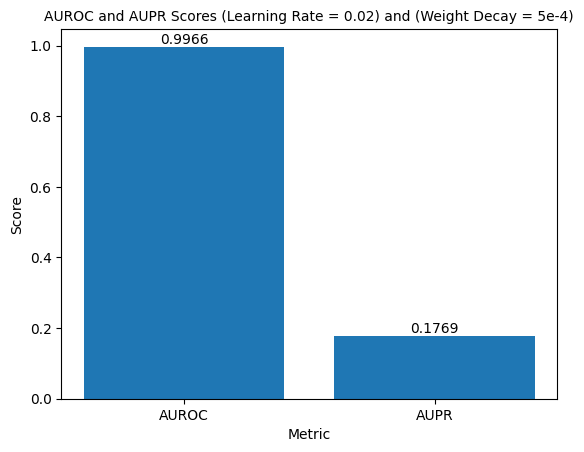

In [ ]:
import numpy as np
import networkx as nx
from sklearn.metrics import roc_auc_score, average_precision_score
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Step 1: Build the graph structure
# Load protein and drug nodes
protein_nodes = np.loadtxt('/content/protein.txt', dtype=str)
drug_nodes = np.loadtxt('/content/drug.txt', dtype=str)

# Load drug-protein interaction matrix
interaction_matrix = np.loadtxt('/content/mat_drug_protein.txt', dtype=int)

# Create an empty graph
graph = nx.Graph()

# Add protein nodes to the graph
for protein_node in protein_nodes:
    graph.add_node(protein_node, type='protein')

# Add drug nodes to the graph
for drug_node in drug_nodes:
    graph.add_node(drug_node, type='drug')

# Add edges based on the interaction matrix
drug_indices, protein_indices = np.nonzero(interaction_matrix)
for drug_index, protein_index in zip(drug_indices, protein_indices):
    drug_node = drug_nodes[drug_index]
    protein_node = protein_nodes[protein_index]
    graph.add_edge(drug_node, protein_node)

# Step 2: Create feature inputs
# Load similarity matrices
similarity_matrix_drugs = np.loadtxt('/content/Similarity_Matrix_Drugs.txt')
similarity_matrix_proteins = np.loadtxt('/content/Similarity_Matrix_Proteins.txt')

# Step 3: Use PyTorch Geometric
# Convert the graph to a PyTorch Geometric Data object
edges = list(graph.edges) #extract the edges from the graph object and convert them into a list.
nodes = set([node for edge in edges for node in edge])

# Convert node names to indices
node_to_index = {node: index for index, node in enumerate(nodes)}
edge_index = []
for edge in edges:
    src_index = node_to_index[edge[0]]
    tgt_index = node_to_index[edge[1]]
    edge_index.append([src_index, tgt_index])

# Create the edge index tensor
edge_index = torch.tensor([[node_to_index[edge[0]] for edge in edges],
                           [node_to_index[edge[1]] for edge in edges]], dtype=torch.long)
#print(edge_index.size())
#print(edges)

# Create the feature matrices
num_nodes = len(nodes)
num_drugs = len(drug_nodes)
num_proteins = len(protein_nodes)

features_drugs = torch.tensor(similarity_matrix_drugs, dtype=torch.float)
features_proteins = torch.tensor(similarity_matrix_proteins, dtype=torch.float)
#print(features_drugs.shape)
#print(features_proteins.shape)

if features_drugs.size(0) > features_proteins.size(0):
    features_drugs = features_drugs[:features_proteins.size(0)]
elif features_drugs.size(0) < features_proteins.size(0):
    features_proteins = features_proteins[:features_drugs.size(0)]

# Create the target labels
labels = torch.tensor(interaction_matrix.flatten(), dtype=torch.float)

# Create the PyTorch Geometric Data object
data = Data(x=torch.cat([features_drugs.T, features_proteins.T]), edge_index=edge_index, y=labels)

# Step 4: GCN model
class GCN(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, 1)
        torch.manual_seed(1)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

num_node_features = 708
hidden_channels = 16
model = GCN(num_node_features, hidden_channels)
print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=0.02,weight_decay=5e-4)
criterion = torch.nn.BCEWithLogitsLoss()

# Define the number of epochs
num_epochs = 400

model.train()
optimizer.zero_grad()

for epoch in range(num_epochs):
    # Perform forward pass
    x = data.x.view(-1, num_node_features)
    out = model(x, data.edge_index).squeeze().view(-1)
    index_range = torch.arange(out.size(0))
    if index_range.size(0) > data.y.size(0):
        index_range = index_range[:data.y.size(0)]
    out = out.index_select(0, index_range)
    target_labels = data.y.view(-1)[:out.size(0)]

    # Compute loss and perform backward pass
    loss = criterion(out, target_labels)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    # Print training progress
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))


model.eval()  # Switch to evaluation mode
# Convert logits to probabilities using sigmoid activation
probs = torch.sigmoid(out)

# Convert probabilities and labels to numpy arrays
target_labels = data.y.view(-1)[:out.size(0)].detach().numpy()
probs = probs.view(-1).detach().numpy()

# Compute AUROC and AUPR scores
auroc = roc_auc_score(target_labels, probs)
aupr = average_precision_score(target_labels, probs)
print("AUROC: {:.4f}".format(auroc))
print("AUPR: {:.4f}".format(aupr))

# Create a bar plot
labels = ['AUROC', 'AUPR']
scores = [auroc, aupr]

plt.bar(labels, scores)
plt.xlabel('Metric')
plt.ylabel('Score')
plt.title('AUROC and AUPR Scores (Learning Rate = 0.02) and (Weight Decay = 5e-4)',fontsize=10)
# Add text annotations to the bars
for i, score in enumerate(scores):
    plt.text(i, score, f'{score:.4f}', ha='center', va='bottom')

plt.show()

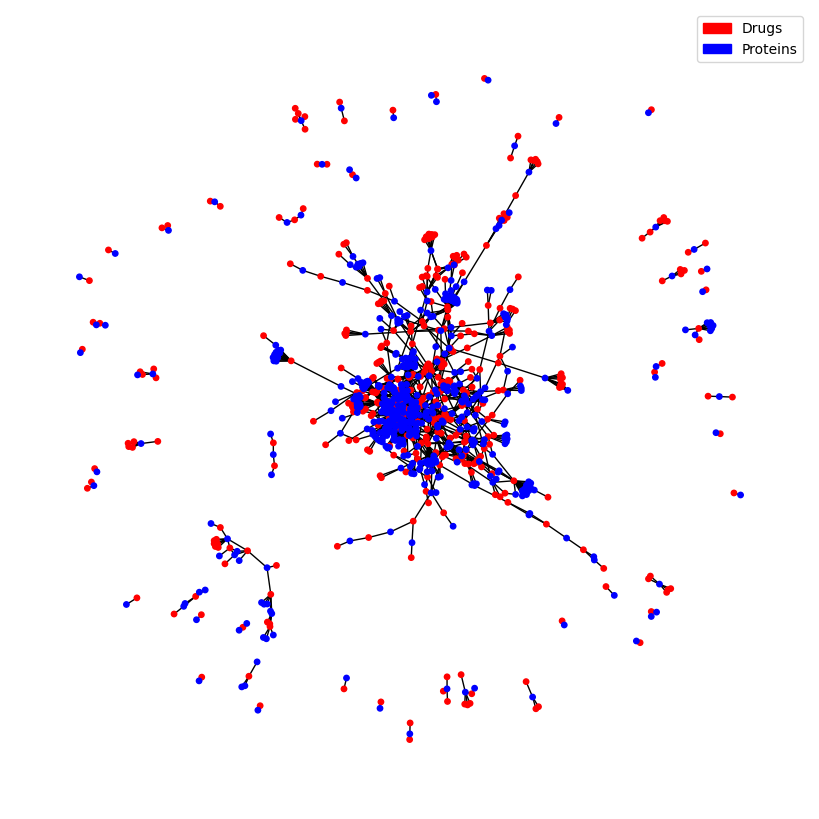

In [ ]:
#Graph Drawing
# Identify isolated nodes
isolated_nodes = list(nx.isolates(graph))

# Remove isolated nodes from the graph
graph.remove_nodes_from(isolated_nodes)
pos = nx.spring_layout(graph)
node_colors = ['blue' if node in drug_nodes else 'red' for node in graph.nodes()]
plt.figure(figsize=(8,8))
nx.draw(graph, pos, node_color=node_colors, with_labels=False, node_size=15)
drug_patch = mpatches.Patch(color='red', label='Drugs')
protein_patch = mpatches.Patch(color='blue', label='Proteins')
plt.legend(handles=[drug_patch, protein_patch], loc='upper right')

# Show the graph
plt.show()

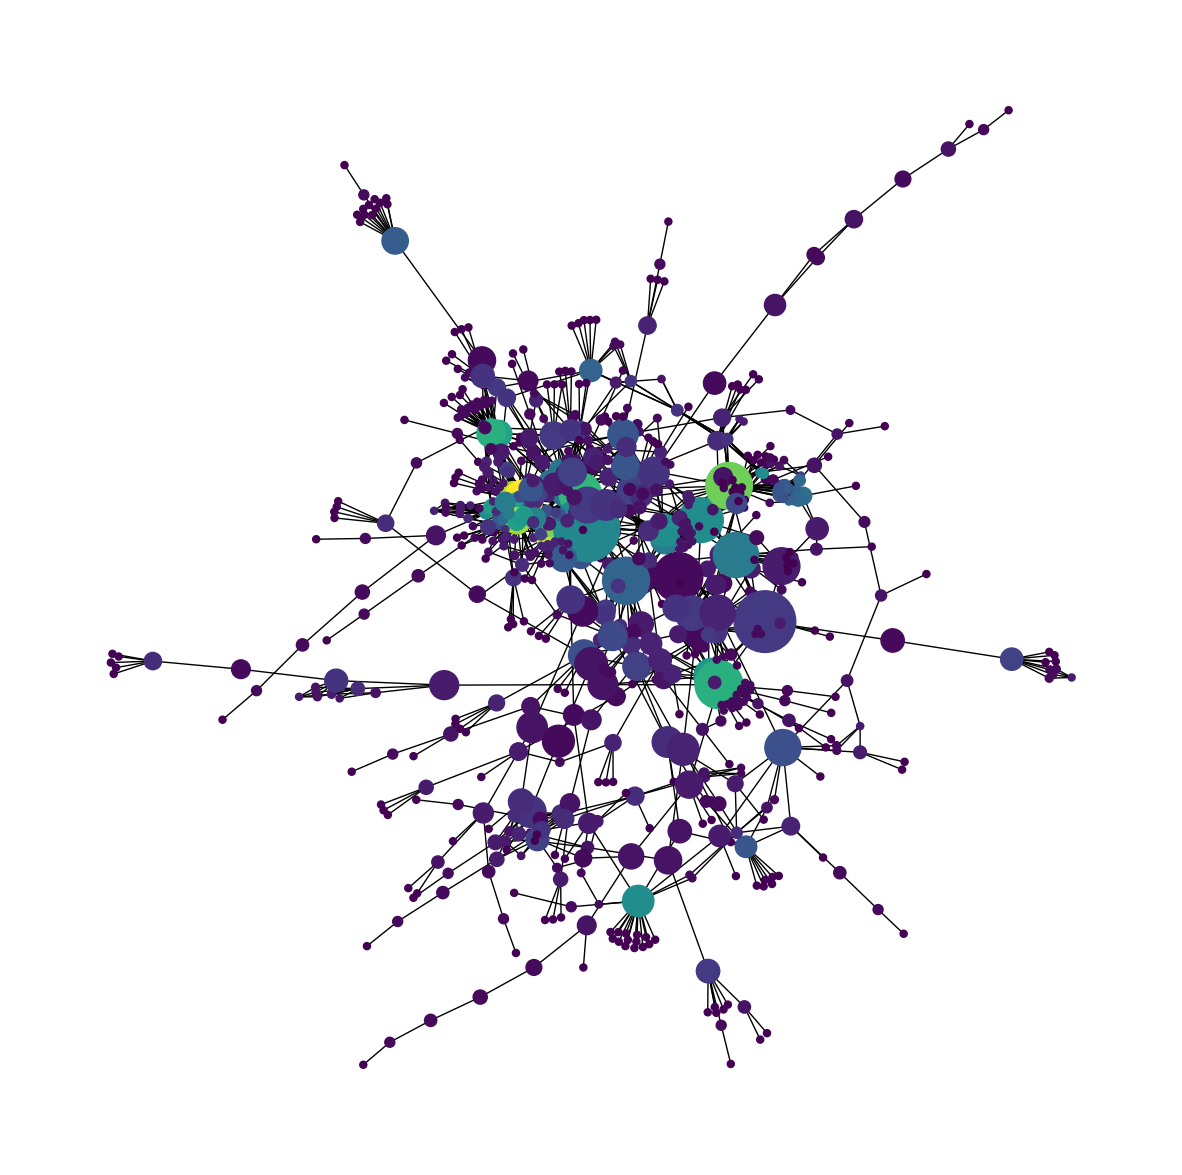

In [ ]:
#Largest Connected Component Network Drawing
#Compute largest connected component of the network(LC)
#list the components in network (g)
components = nx.connected_components(graph)
#compare among components and find the one having maximun length(LC)
largest_component = max(components, key=len)
# Q1.draw LC
subgraph = graph.subgraph(largest_component)
pos = nx.spring_layout(subgraph) # force nodes to separte 
betCent = nx.betweenness_centrality(subgraph, normalized=True, endpoints=True)
node_color = [20000.0 * graph.degree(v) for v in subgraph]
node_size =  [v * 10000 for v in betCent.values()]
plt.figure(figsize=(15,15))
nx.draw_networkx(subgraph, pos=pos, with_labels=False,
                 node_color=node_color,
                 node_size=node_size)
plt.axis('off')
plt.show()

Average degree:  3.9587628865979383


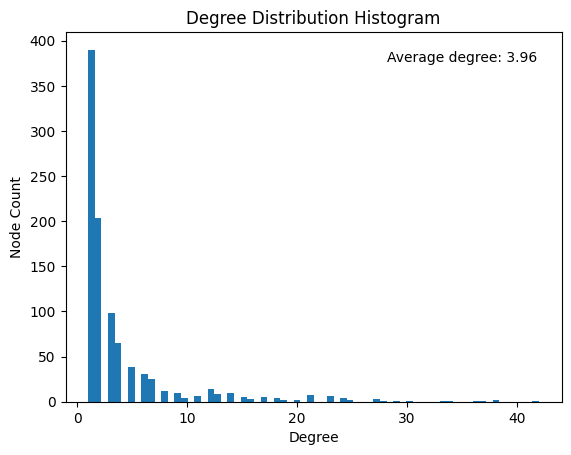

In [ ]:
#Degree Distribution Histogram Drawing
#Calculate degree sequence
degree_sequence = sorted([d for n, d in graph.degree()], reverse=True)
degrees = [deg for (node, deg) in nx.degree(graph)]  # The degrees of each node
avg_degree = sum(degrees) / float(len(degrees))
print('Average degree: ', avg_degree )
# Create histogram for degree distribution
plt.hist(degree_sequence, bins='auto')
plt.title("Degree Distribution Histogram")
plt.xlabel("Degree")
plt.ylabel("Node Count")
plt.text(0.95, 0.95, f'Average degree: {avg_degree:.2f}', ha='right', va='top', transform=plt.gca().transAxes)

plt.show()


In [ ]:
#Show the state of the graph
def printGraphState(g):
    """
    Prints out the number of nodes, edges(g)
    """
    print("# nodes: " + str(g.number_of_nodes()))
    print(g.nodes())
    print("# edges: " + str(g.number_of_edges()))
    print(g.edges())

printGraphState(graph)  

# nodes: 970
['P35228', 'P30542', 'P00519', 'P23219', 'P21728', 'P35916', 'P51168', 'Q9H4B7', 'P17948', 'Q9UPY5', 'P04049', 'P24530', 'P20309', 'P00734', 'P48167', 'P21554', 'P30556', 'P34995', 'Q07869', 'P51843', 'P00492', 'P28702', 'Q13639', 'Q12809', 'P11229', 'P34972', 'Q9H244', 'P25021', 'P09622', 'Q05940', 'P03372', 'P24046', 'P69905', 'P10275', 'P05091', 'P22888', 'P09172', 'P07437', 'P13631', 'P21918', 'Q9H3N8', 'P36888', 'O00180', 'Q9NYK1', 'Q99720', 'P15692', 'P37288', 'P08588', 'Q9Y5Y9', 'P00367', 'O76074', 'P37088', 'Q14524', 'P30968', 'P09619', 'P10826', 'Q09428', 'P00747', 'P37231', 'P00742', 'Q9UBS5', 'P16083', 'P12821', 'P07327', 'P05121', 'P29275', 'P10109', 'P10415', 'P08912', 'P09917', 'P30531', 'P00491', 'P14679', 'P80404', 'Q9Y478', 'P10745', 'P49902', 'P35354', 'P29474', 'P00797', 'P55011', 'P08913', 'P08908', 'P30518', 'P09455', 'P46098', 'Q8IVH4', 'P00918', 'P04818', 'P23921', 'P49286', 'P00374', 'P18825', 'P05093', 'P16471', 'P39086', 'P19801', 'P78348', 'O0055